In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime
from collections import Counter
from scipy import stats
import itertools
import math
import operator
import json
import util

In [2]:
# Config

BENCHMARK = "TPCH"
CHUNK_SIZE = 65535

if BENCHMARK == "TPCH":
    SCALE_FACTOR = 10
    RUNS = 10
    TIME = 500
    #STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/TPC-H__SF_{SCALE_FACTOR}.000000__RUNS_{RUNS}__TIME_{TIME}__ENCODING_DictionaryFSBA"
    #STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/TPCH-BASE"
    STATISTICS_PATH = "~/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/l_orderkey-100"
    
elif BENCHMARK == "TPCDS":
    SCALE_FACTOR = 10
    RUNS = 1
    TIME = 60
    #STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/TPC-DS__SF_{SCALE_FACTOR}.000000__RUNS_{RUNS}__TIME_{TIME}__ENCODING_DictionaryFSBA"
    STATISTICS_PATH = "~/Dokumente/repos/example_plugin/stats/final/tpcds/sf10-2d/nosort"
else:
    raise Exception("Unknown benchmark: " + BENCHMARK)

print(f"Model is configured for {BENCHMARK} (chunk size {CHUNK_SIZE}) with scale factor {SCALE_FACTOR}, {TIME} seconds runtime, and at most {RUNS} runs per query")

Model is configured for TPCH (chunk size 65535) with scale factor 10, 500 seconds runtime, and at most 10 runs per query


In [3]:
# Load table scan statistics

path = f"{STATISTICS_PATH}/table_scans.csv"
scans = pd.read_csv(path, sep='|')
EXPECTED_SCAN_COUNT = len(scans)
LOADED_CHUNK_SIZE = CHUNK_SIZE
LOADED_BENCHMARK = BENCHMARK
LOADED_SCALE_FACTOR = SCALE_FACTOR
LOADED_RUNS = RUNS
LOADED_TIME = TIME

print(f"Successfully loaded {path}")

def assert_correct_statistics_loaded():
    assert BENCHMARK == LOADED_BENCHMARK, f"The model is configured to use {BENCHMARK}, but {LOADED_BENCHMARK} is currently loaded.\nEither change the benchmark or re-run all cells"
    assert SCALE_FACTOR == LOADED_SCALE_FACTOR, f"The model is configured to use {SCALE_FACTOR} as scale factor, but data for a scale factor of {LOADED_SCALE_FACTOR} is currently loaded.\nEither change the benchmark or re-run all cells"
    assert RUNS == LOADED_RUNS, f"The model is configured to perform at most {RUNS} runs, but the currently loaded data had at most {LOADED_RUNS} runs.\nEither change the benchmark or re-run all cells"
    assert TIME == LOADED_TIME, f"The model is configured to run for {TIME} seconds, but the currently data had a runtime of {LOADED_TIME} seconds.\nEither change the benchmark or re-run all cells"
    assert CHUNK_SIZE == LOADED_CHUNK_SIZE, f"The model is configured to use {CHUNK_SIZE} as chunk_size, but data for a chunk size of {LOADED_CHUNK_SIZE} is currently loaded.\nEither change the benchmark or re-run all cells"
    assert EXPECTED_SCAN_COUNT == len(scans), f"There should be {EXPECTED_SCAN_COUNT} table scans, but there are only {len(scans)}\nProbably one of the last commands reassigned it unintentionally"
    
    assert 'GET_TABLE_HASH' in scans.columns, f"the statistics in {STATISTICS_PATH} are outdated (column 'GET_TABLE_HASH' in table_scans.csv is missing). Please create them again."

Successfully loaded ~/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/l_orderkey-100/table_scans.csv


In [4]:
# Validate table scans
assert_correct_statistics_loaded()

# To make sure pruning was not active,
# first fetch table sizes,
table_statistics = pd.read_csv(f"{STATISTICS_PATH}/table_meta_data.csv", sep='|')
table_sizes = dict(zip(table_statistics.TABLE_NAME, table_statistics.ROW_COUNT))

# then make sure INPUT_ROW_COUNT == table_size
def input_size_matches(row):
    #print(row)
    
    actual_row_count = row['INPUT_ROW_COUNT']
    table = row['TABLE_NAME']
    expected_row_count = table_sizes[table]
    return expected_row_count == actual_row_count

data_scans = scans[scans['COLUMN_TYPE'] == 'DATA']
input_size_matches = data_scans.apply(input_size_matches, axis=1)
all_sizes_match = reduce(np.logical_and, input_size_matches) #input_size_matches.apply()

if not all_sizes_match:
    #raise Exception("The given statistics were probably created while pruning was active")
    pass
else:
    print("OK - looks like pruning was deactivated while the statistics were created")

OK - looks like pruning was deactivated while the statistics were created


In [5]:
# Append additional information to the table scans
assert_correct_statistics_loaded()

print(f"Statistics for {BENCHMARK} contain {len(scans)} table scans")


# Add statistics about selectivity and speed for each operator
scans['selectivity'] = scans['OUTPUT_ROW_COUNT'] / scans['INPUT_ROW_COUNT']

# TODO: Assumption that reading and writing a row have the same cost
scans['time_per_row'] = scans['RUNTIME_NS'] / (scans['INPUT_ROW_COUNT'] + scans['OUTPUT_ROW_COUNT'])
scans['time_per_input_row'] = scans['time_per_row']
scans['time_per_output_row'] = scans['time_per_row']


def determine_or_chains(table_scans):
    table_scans['part_of_or_chain'] = False
    
    single_table_scans = table_scans.groupby(['QUERY_HASH', 'TABLE_NAME', 'GET_TABLE_HASH'])
    
    for _, scans in single_table_scans:
        input_row_frequencies = Counter(scans.INPUT_ROW_COUNT)
        or_input_sizes = set([input_size for input_size, frequency in input_row_frequencies.items() if frequency > 1])

        df = pd.DataFrame()
        df['INPUT_ROW_COUNT'] = scans['INPUT_ROW_COUNT']
        df['OUTPUT_ROW_COUNT'] = scans['OUTPUT_ROW_COUNT']
        df['part_of_or_chain'] = scans.apply(lambda row: row['INPUT_ROW_COUNT'] in or_input_sizes, axis=1)

        for _ in range(len(scans)):
            or_input_sizes |= set(df[df['part_of_or_chain']].OUTPUT_ROW_COUNT.unique())
            df['part_of_or_chain'] = df.apply(lambda row: row['INPUT_ROW_COUNT'] in or_input_sizes, axis=1)

        or_chains = list(df[df['part_of_or_chain']].index)
        #table_scans.iloc[or_chains, table_scans.columns.get_loc('part_of_or_chain')] = True
        table_scans.loc[or_chains, 'part_of_or_chain'] = True
    
    return table_scans

# Hyrise does not use scans that are part of an OR-chain for pruning
scans = determine_or_chains(scans)


# Like scans are not useful if they start with %
# TODO what if they dont start with % and contain more than one % ? -> up to first % prunable, but is it used?
def benefits_from_sorting(row):    
    description = row['DESCRIPTION']
    if "ColumnLike" in description:
        words = description.split('LIKE')
        assert len(words) == 2, f"expected exactly one occurence of LIKE, but got {description}"
        like_criteria = words[1]
        assert "%" in like_criteria or "_" in like_criteria, f"LIKE operators should have an % or _, but found none in {like_criteria}"
        first_char = like_criteria[2]
        assert first_char != ' ' and first_char != "'", "Like check considers the wrong token"
        return first_char != '%' and first_char != '_'
    elif "ExpressionEvaluator" in description and " IN " in description:
        return False
    else:
        return True

scans['benefits_from_sorting'] = scans.apply(benefits_from_sorting, axis=1)
# TODO: valid atm, but feels a bit hacky to assume not benefitting from sorted segments -> not benefitting from pruning
scans['useful_for_pruning'] = scans.apply(lambda row: not row['part_of_or_chain'] and row['benefits_from_sorting'] , axis=1)
EXPECTED_SCAN_COUNT = len(scans)
print(f"Of those, only {len(scans[scans['useful_for_pruning']])} are useful for pruning")

print("TODO: For now, filtering on scans is deactivated. This is because all scans are needed to recognize OR-Chains. Models have to take care themselves whether a scan can contribute to pruning or not")

Statistics for TPCH contain 435 table scans
Of those, only 227 are useful for pruning
TODO: For now, filtering on scans is deactivated. This is because all scans are needed to recognize OR-Chains. Models have to take care themselves whether a scan can contribute to pruning or not


In [6]:
def test_determine_or_chains():
    test = pd.DataFrame()
    test['QUERY_HASH'] = pd.Series(['1']*3  + ['2']*4)
    test['TABLE_NAME'] = pd.Series(['lineitem']*3  + ['part']*4)
    test['GET_TABLE_HASH'] = pd.Series(['0x1'] + ['0x2']*2 + ['0x3']*4)
    test['COLUMN_NAME'] = pd.Series(['l_shipdate', 'l_shipdate', 'l_discount', 'p_brand', 'p_type', 'p_type', 'p_size'])
    test['INPUT_ROW_COUNT'] = pd.Series( [6001215, 6001215, 200000, 200000, 199000, 199000, 50000])
    test['OUTPUT_ROW_COUNT'] = pd.Series([ 400000,  300000, 200000, 199000,      0,  50000, 20000])
    test_result = determine_or_chains(test)
    assert len(test_result) == 7, "should not filter out any rows"    
    assert len(test_result[test_result['part_of_or_chain']]) == 3, "expected 3 scans, got\n" + str(test_result)
    assert list(test_result['part_of_or_chain']) == [False]*4 + [True]*3
    print("Test OK")

test_determine_or_chains()

Test OK


In [7]:
# Load query frequency information
assert_correct_statistics_loaded()

def get_query_frequencies():
    plan_cache = pd.read_csv(f"{STATISTICS_PATH}/plan_cache.csv", sep='|')
    return dict(zip(plan_cache.QUERY_HASH, plan_cache.EXECUTION_COUNT))

#get_query_frequencies()

In [8]:
# Load column statistics - especially interesting: number of distinct values, and columns sorted during statistics creation

# Returns a 2-level-dictionary: distinct_values[TABLE][COLUMN] = number_of_distinct_values
def get_distinct_values_count():        
    # Code
    column_statistics_df = pd.read_csv(f"{STATISTICS_PATH}/column_meta_data.csv", sep='|')
    column_statistics_df['DISTINCT_VALUES'] = np.int32(column_statistics_df['DISTINCT_VALUES'])
    tables_and_columns = column_statistics_df.groupby('TABLE_NAME')
    distinct_values = {table: dict(zip(column_df.COLUMN_NAME, column_df.DISTINCT_VALUES)) for table, column_df in tables_and_columns }

    
    # Test
    num_tables = len(distinct_values)
    if BENCHMARK == "TPCH":
        assert num_tables == 8, f"TPCH has 8 tables, but got {num_tables}"
    elif BENCHMARK == "TPCDS":
        assert num_tables == 24, f"TPCDS has 24 tables, but got {num_tables}"
    else:
        assert False, "Insert a benchmark specific check here"
    
    return distinct_values

# Returns a dictionary: sorted_columns_during_creation[TABLE] = [column1, column2, ...]
def get_sorted_columns_during_creation():
    # Code
    column_statistics_df = pd.read_csv(f"{STATISTICS_PATH}/column_meta_data.csv", sep='|')
    globally_sorted_columns = column_statistics_df[column_statistics_df['IS_GLOBALLY_SORTED'] == 1]
    
    tables_and_columns = globally_sorted_columns.groupby('TABLE_NAME')
    globally_sorted_columns = {table: list(column_df.COLUMN_NAME) for table, column_df in tables_and_columns }
    
    return globally_sorted_columns

#get_distinct_values_count()
#get_sorted_columns_during_creation()

In [9]:
### JOINS ###

assert_correct_statistics_loaded()

def load_join_statistics(path=STATISTICS_PATH):
    def line_looks_suspicious(row):
        right_table_name = row['RIGHT_TABLE_NAME']    
        if pd.isnull(right_table_name):
            pass
        elif row['RIGHT_TABLE_ROW_COUNT'] > table_sizes[row['RIGHT_TABLE_NAME']]:
            return True

        left_table_name = row['LEFT_TABLE_NAME']
        if pd.isnull(left_table_name):
            pass
        elif row['LEFT_TABLE_ROW_COUNT'] > table_sizes[row['LEFT_TABLE_NAME']]:
            return True

        return False
    
    def validate_joins(joins):
        is_suspicious = joins.apply(line_looks_suspicious, axis=1)
        suspicious_joins = joins[is_suspicious]
        assert len(suspicious_joins) < 4, f"there are {len(suspicious_joins)} suspicious joins:\n{suspicious_joins[['JOIN_MODE', 'LEFT_TABLE_NAME', 'LEFT_COLUMN_NAME', 'LEFT_TABLE_ROW_COUNT', 'RIGHT_TABLE_NAME', 'RIGHT_COLUMN_NAME', 'RIGHT_TABLE_ROW_COUNT', 'OUTPUT_ROW_COUNT']]}"
    
    joins = pd.read_csv(f"{path}/joins.csv", sep='|')
    joins = joins.dropna()
    joins['PROBE_TABLE'] = joins.apply(lambda x: x[x['PROBE_SIDE'] + "_TABLE_NAME"] if not x['PROBE_SIDE'] == "NULL" else "NULL", axis=1)
    joins['PROBE_COLUMN'] = joins.apply(lambda x: x[x['PROBE_SIDE'] + "_COLUMN_NAME"] if not x['PROBE_SIDE'] == "NULL" else "NULL", axis=1)
    joins['PROBE_TABLE_ROW_COUNT'] = joins.apply(lambda x: x[x['PROBE_SIDE'] + "_TABLE_ROW_COUNT"]if not x['PROBE_SIDE'] == "NULL" else "NULL" , axis=1)
    joins['BUILD_TABLE'] = joins.apply(lambda x: x[x['BUILD_SIDE'] + "_TABLE_NAME"] if not x['BUILD_SIDE'] == "NULL" else "NULL", axis=1)
    joins['BUILD_COLUMN'] = joins.apply(lambda x: x[x['BUILD_SIDE'] + "_COLUMN_NAME"] if not x['BUILD_SIDE'] == "NULL" else "NULL", axis=1)
    joins['BUILD_TABLE_ROW_COUNT'] = joins.apply(lambda x: x[x['BUILD_SIDE'] + "_TABLE_ROW_COUNT"] if not x['BUILD_SIDE'] == "NULL" else "NULL", axis=1)
    validate_joins(joins)    
                                                                                           
    tmp = joins['BUILD_SORTED'].copy()
    joins['BUILD_SORTED'] = joins['PROBE_SORTED'].copy()
    joins['PROBE_SORTED'] = tmp
    
    return joins

load_join_statistics()#.iloc[50:60][['JOIN_MODE', 'LEFT_TABLE_NAME', 'LEFT_COLUMN_NAME', 'LEFT_TABLE_ROW_COUNT', 'RIGHT_TABLE_NAME', 'RIGHT_COLUMN_NAME', 'RIGHT_TABLE_ROW_COUNT', 'OUTPUT_ROW_COUNT']]

,OPERATOR_TYPE,QUERY_HASH,OPERATOR_HASH,LEFT_INPUT_OPERATOR_HASH,RIGHT_INPUT_OPERATOR_HASH,JOIN_MODE,LEFT_TABLE_NAME,LEFT_COLUMN_NAME,LEFT_TABLE_CHUNK_COUNT,LEFT_TABLE_ROW_COUNT,...,PROBE_SORTED,BUILD_SORTED,PROBE_SIDE,BUILD_SIDE,PROBE_TABLE,PROBE_COLUMN,PROBE_TABLE_ROW_COUNT,BUILD_TABLE,BUILD_COLUMN,BUILD_TABLE_ROW_COUNT
0,JOIN,af04794535660bfb,0x7f84827bbe10dd4dc64d29ae9b3,0x7f84827bde7055b7494ac229582a,0x7f84827bccf0f0a08f0547c145d7,Semi,lineitem,l_partkey,958,59986052,...,1,0,LEFT,RIGHT,lineitem,l_partkey,59986052,part,p_partkey,4829
1,JOIN,af04794535660bfb,0x7f84827bcb30d1faaf75a5343b7a,0x7f85b0ce7090cb575316bcc4b3c6,0x7f84827bccf0f0a08f0547c145d7,Inner,lineitem,l_partkey,940,5041,...,0,0,LEFT,RIGHT,lineitem,l_partkey,5041,part,p_partkey,4829
2,JOIN,a61d21fbe175bdf5,0x7f85000c3dd058c14a6cca7fd588,0x7f85000c5030957ab2b9be2ee822,0x7f85000c3cf04e6d730f0e6fa4a7,Semi,partsupp,ps_partkey,123,8000000,...,1,0,LEFT,RIGHT,partsupp,ps_partkey,8000000,part,p_partkey,297275
3,JOIN,a61d21fbe175bdf5,0x7f85000c4af03fe99be327301a77,0x7f85bb9393d0902726fedb3d53c4,0x7f85d4082610405c1df25812b514,AntiNullAsTrue,partsupp,ps_suppkey,4,1189100,...,0,1,LEFT,RIGHT,partsupp,ps_suppkey,1189100,supplier,s_suppkey,56
4,JOIN,a61d21fbe175bdf5,0x7f85000c4bd0ae8d96ee6c9e7d67,0x7f85000c4af03fe99be327301a77,0x7f85000c3cf04e6d730f0e6fa4a7,Inner,partsupp,ps_partkey,4,1188457,...,0,0,LEFT,RIGHT,partsupp,ps_partkey,1188457,part,p_partkey,297275
5,JOIN,550d82dfc9e49105,0x7f84cfc4cbd01e575dd66d6f4fef,0x7f84c2e7a9f055b7494ac229582a,0x7f84cfc4caf0ce6481facf33f2b8,Semi,lineitem,l_partkey,958,59986052,...,1,0,LEFT,RIGHT,lineitem,l_partkey,59986052,part,p_partkey,4884
6,JOIN,550d82dfc9e49105,0x7f84c2e79db0fc4d17ba0c2493bb,0x7f85b0ce87b0f5c354e4163dff9b,0x7f84cfc4caf0ce6481facf33f2b8,Inner,lineitem,l_partkey,937,5228,...,0,0,LEFT,RIGHT,lineitem,l_partkey,5228,part,p_partkey,4884
7,JOIN,3534234c34669919,0x7f84827c1e50c4ffbe539f9390cd,0x7f848ff540f0a894a64836f37e3f,0x7f85c84028d03ebb5223006cec8b,Semi,partsupp,ps_partkey,123,8000000,...,1,1,LEFT,RIGHT,partsupp,ps_partkey,8000000,part,p_partkey,21783
8,JOIN,3534234c34669919,0x7f84827c0950c5eaf493caf4e88d,0x7f84827c0870cb7e53f5b99e8f3a,0x7f85b0ce85d02852fe66e976776e,Semi,lineitem,l_partkey,958,59986052,...,1,1,LEFT,RIGHT,lineitem,l_partkey,59986052,partsupp,ps_partkey,87132
9,JOIN,3534234c34669919,0x7f84827c0a30cfa286d873342e51,0x7f84827c0950c5eaf493caf4e88d,0x7f85b0ce85d02852fe66e976776e,Semi,lineitem,l_suppkey,958,652766,...,1,1,LEFT,RIGHT,lineitem,l_suppkey,652766,partsupp,ps_suppkey,87132


In [10]:
# Extract interesting table names
# Currently fixed to columns which are scanned or used in joins

def get_table_names(table_scans, joins):
    scan_tables = set(table_scans['TABLE_NAME'].unique())
    left_join_tables = set(joins['LEFT_TABLE_NAME'].unique())
    right_join_tables = set(joins['RIGHT_TABLE_NAME'].unique())    

    return scan_tables.union(left_join_tables.union(right_join_tables))


In [11]:
class AbstractModel:
    
    def __init__(self, query_frequencies, table_name, table_scans, correlations={}):
        self.query_frequencies = query_frequencies
        self.table_name = table_name
        self.table_scans = table_scans
        self.correlations = correlations
        
    def query_frequency(self, query_hash):
        return self.query_frequencies[query_hash]
        
    def extract_scan_columns(self):
        useful_scans = self.table_scans[self.table_scans['useful_for_pruning']]
        interesting_scan_columns = list(useful_scans['COLUMN_NAME'].unique())
        
        return interesting_scan_columns
    
    def extract_join_columns(self):
        interesting_join_probe_columns = list(self.joins[self.joins['PROBE_TABLE'] == self.table_name]['PROBE_COLUMN'].unique())
        interesting_join_build_columns = list(self.joins[self.joins['BUILD_TABLE'] == self.table_name]['BUILD_COLUMN'].unique())        
        
        return self.uniquify(interesting_join_probe_columns + interesting_join_build_columns)
    
    def extract_interesting_columns(self):        
        return self.uniquify(self.extract_scan_columns() + self.extract_join_columns())
    
    def round_up_to_next_multiple(self, number_to_round, base_for_multiple):
        quotient = number_to_round // base_for_multiple
        if number_to_round % base_for_multiple != 0:
            quotient += 1
        return quotient * base_for_multiple        

    def uniquify(self, seq):
            seen = set()
            return [x for x in seq if not (x in seen or seen.add(x))]    
    
    # return a list of possible clusterings
    def suggest_clustering(self, first_k=1):
        raise NotImplemented()

In [12]:
class SingleTableMdcModel(AbstractModel):
    
    def __init__(self, max_dimensions, query_frequencies, table_name, table_scans, table_sizes, distinct_values, target_chunksize, correlations, joins, sorted_columns_during_creation):
        super().__init__(query_frequencies, table_name, table_scans, correlations)
        self.max_dimensions = max_dimensions
        self.table_sizes = table_sizes       
        self.table_size = table_sizes[table_name]
        self.distinct_values = distinct_values
        self.target_chunksize = target_chunksize
        self.joins = joins
        self.sorted_columns_during_creation = sorted_columns_during_creation
        
        
        self.join_column_names = self.extract_join_columns()
        self.scan_column_names = self.extract_scan_columns()
        
        self.scan_estimates = pd.DataFrame()
        self.scan_estimates['QUERY_HASH'] = self.table_scans['QUERY_HASH']        
        self.scan_estimates['DESCRIPTION'] = self.table_scans['DESCRIPTION']
        self.scan_estimates['RUNTIME_ESTIMATE'] = np.array([-1] * len(self.table_scans))
        self.scan_estimates['RUNTIME_NS'] = self.table_scans['RUNTIME_NS'] # TODO: probably not necessary?
        self.scan_estimates['time_per_input_row'] = self.table_scans['time_per_input_row']
        #self.scan_estimates.index = self.table_scans.index
        
        self.join_estimates = pd.DataFrame()
        self.join_estimates['QUERY_HASH'] = self.joins['QUERY_HASH']
        self.join_estimates['DESCRIPTION'] = self.joins['DESCRIPTION']
        self.join_estimates['ESTIMATE_BUILD_SIDE_MATERIALIZING'] = np.array([-1] * len(self.joins))
        self.join_estimates['ESTIMATE_PROBE_SIDE_MATERIALIZING'] = np.array([-1] * len(self.joins))
        self.join_estimates['ESTIMATE_CLUSTERING'] = np.array([-1] * len(self.joins))
        self.join_estimates['ESTIMATE_BUILDING'] = np.array([-1] * len(self.joins))
        self.join_estimates['ESTIMATE_PROBING'] = np.array([-1] * len(self.joins))
        self.join_estimates['ESTIMATE_OUTPUT_WRITING'] = np.array([-1] * len(self.joins))
        self.join_estimates['BUILD_SIDE_MATERIALIZING_NS'] = self.joins['BUILD_SIDE_MATERIALIZING_NS']
        self.join_estimates['PROBE_SIDE_MATERIALIZING_NS'] = self.joins['PROBE_SIDE_MATERIALIZING_NS']
        self.join_estimates['CLUSTERING_NS'] = self.joins['CLUSTERING_NS']
        self.join_estimates['BUILDING_NS'] = self.joins['BUILDING_NS']
        self.join_estimates['PROBING_NS'] = self.joins['PROBING_NS']
        self.join_estimates['OUTPUT_WRITING_NS'] = self.joins['OUTPUT_WRITING_NS']
        
    def is_join_column(self, column_name):
        return column_name in self.join_column_names
    
    def is_scan_column(self, column_name):
        return column_name in self.scan_column_names
    
    def suggest_clustering(self, first_k=1):
        interesting_columns = self.extract_interesting_columns()

        print(interesting_columns)
        clustering_columns = itertools.combinations_with_replacement(interesting_columns, self.max_dimensions)
        clustering_columns = [self.uniquify(clustering) for clustering in clustering_columns]
        print(f"There are {len(clustering_columns)} clustering column sets")
        
        reduced_clustering_columns = []
        seen_clusterings = set()
        for clustering in clustering_columns:
            clustering_string = "-".join(clustering)
            if clustering_string not in seen_clusterings:
                seen_clusterings.add(clustering_string)
                reduced_clustering_columns.append(clustering)
        clustering_columns = reduced_clustering_columns
        
        
        print(f"{len(clustering_columns)} of them are unique")
        sort_columns = interesting_columns        
        clusterings_with_runtimes = reduce(lambda x,y: x+y,[self.estimate_total_runtimes(clustering_cols, sort_columns) for clustering_cols in clustering_columns])
        clusterings_with_runtimes.sort(key=lambda x: x[2], reverse=False)
        
        return clusterings_with_runtimes[0:first_k]
    
    
    def estimate_distinct_values_per_chunk(self, column, clustering_columns, sorting_column, dimension_cardinalities):
        raise NotImplementedError("Each model should provide this function")
        
    def estimate_distinct_values_per_chunk_at_statistics_time(self, column, table):        
        if column in self.sorted_columns_during_creation.get(table, {}):
            # Column was globally sorted
            average_count_per_distinct_value = self.table_sizes[table] / self.distinct_values[table][column]
            return math.ceil(self.target_chunksize / average_count_per_distinct_value)
        else:
            # Column was not globally sorted
            total_distinct_values = self.distinct_values[table][column]
            return min(total_distinct_values, self.target_chunksize)        
    
    def compute_unprunable_parts(self, row, clustering_columns, split_factors):
        def clustering_columns_correlated_to(column):
            return [clustering_column for clustering_column in clustering_columns if column in self.correlations.get(clustering_column, {})]

        def correlates_to_clustering_column(column):
            return len(clustering_columns_correlated_to(column)) > 0

        column_name = row['COLUMN_NAME']

        if not row['useful_for_pruning']:
            selectivity = 1
        elif column_name in clustering_columns:
            scan_selectivity = row['selectivity']
            split_factor = split_factors[clustering_columns.index(column_name)]
            selectivity =  self.round_up_to_next_multiple(scan_selectivity, 1 / split_factor)
        elif correlates_to_clustering_column(column_name):
            scan_selectivity = row['selectivity']
            correlated_clustering_columns = clustering_columns_correlated_to(column_name)

            # ToDo this is hacky, but for now assume there is just one correlated column
            assert len(correlated_clustering_columns) == 1, f"expected just 1 correlated clustering column, but got {len(correlated_clustering_columns)}"

            split_factor = split_factors[clustering_columns.index(correlated_clustering_columns[0])]
            selectivity = min(1, 1.2 * self.round_up_to_next_multiple(scan_selectivity, 1 / split_factor))
        else:
            selectivity = 1

        return selectivity
    
    def estimate_table_scan_runtime(self, clustering_columns, sorting_column, split_factors):                
        def compute_tablescan_runtime(row, sorting_column):
            assert row['estimated_input_rows'] > 1, row
            assert row['runtime_per_input_row'] > 0, row
            assert row['runtime_per_output_row'] > 0, row
            input_row_count = row['estimated_input_rows']
            
            if row['COLUMN_NAME'] == sorting_column and row['benefits_from_sorting'] and not row['COLUMN_NAME'] in self.sorted_columns_during_creation.get(self.table_name, {}):
                # TODO is this the best way to simulate sorted access?
                input_row_count = np.log2(input_row_count)

            runtime = input_row_count * row['runtime_per_input_row'] + row['OUTPUT_ROW_COUNT'] * row['runtime_per_output_row']
            return runtime * self.query_frequency(row['QUERY_HASH'])
        
        original_clustering_column = self.sorted_columns_during_creation[self.table_name][0]
        
        
        runtime = 0
        scans_per_query = self.table_scans.sort_values(['INPUT_ROW_COUNT'], ascending=False).groupby(['QUERY_HASH', 'GET_TABLE_HASH'])
        for _, scans in scans_per_query:
            number_of_scans = len(scans)
            assert number_of_scans > 0 and number_of_scans < 25, f"weird scan length: {number_of_scans}\nScans:\n{scans}"
            # TODO: kinda unrealistic assumption: everything not in the table scan result can be pruned            

            unprunable_parts = scans.apply(self.compute_unprunable_parts, axis=1, args=(clustering_columns, split_factors,))
            unprunable_part = unprunable_parts.product()
            assert unprunable_part > 0, "no unprunable part"
            
            estimated_pruned_table_size = min(self.table_size, self.round_up_to_next_multiple(unprunable_part * self.table_size, CHUNK_SIZE))
            
            runtimes = pd.DataFrame()
            runtimes['QUERY_HASH'] = scans['QUERY_HASH']
            runtimes['runtime_per_input_row'] = scans['time_per_input_row']
            runtimes['runtime_per_output_row'] = scans['time_per_output_row']
            runtimes['COLUMN_NAME'] = scans['COLUMN_NAME']
            runtimes['benefits_from_sorting'] = scans['benefits_from_sorting']
            # the pruned table inputs should be reflected in 'estimated_input_rows'
            runtimes['estimated_input_rows'] = scans['INPUT_ROW_COUNT']
            runtimes['OUTPUT_ROW_COUNT'] = scans['OUTPUT_ROW_COUNT']

            runtimes.iloc[0, runtimes.columns.get_loc('estimated_input_rows')] = estimated_pruned_table_size
            assert runtimes['estimated_input_rows'].iloc[0] == estimated_pruned_table_size, f"value is {runtimes.iloc[0]['estimated_input_rows']}, but should be {estimated_pruned_table_size}"
            # TODO modify input sizes of subsequent scans
            
            scan_runtimes = runtimes.apply(compute_tablescan_runtime, axis=1, args=(sorting_column,))
            #self.table_scans.iloc[:, self.table_scans.columns.get_loc('RUNTIME_ESTIMATE')] = scan_runtimes
            self.scan_estimates.loc[scan_runtimes.index, 'RUNTIME_ESTIMATE'] = scan_runtimes
            runtime += scan_runtimes.sum()
        return runtime

    def estimate_chunk_count(self, scans, clustering_columns, dimension_cardinalities):
        raise NotImplementedError("Subclass responsibility")
    
    def get_chunk_count_factor(self, row, side, clustering_columns, dimension_cardinalities):
        query_hash = row['QUERY_HASH']
        if side == "PROBE":
            input_rows = row['PROBE_TABLE_ROW_COUNT']
            assert row['PROBE_TABLE'] == self.table_name, "Call this function only for the own table"
            
            # When joining tables, the table size might increase (a lot). This makes it hard to estimate the chunk count, so just ignore it
            if input_rows > self.table_size:
                return 1
        elif side == "BUILD":
            input_rows = row['BUILD_TABLE_ROW_COUNT']
            assert row['BUILD_TABLE'] == self.table_name, "Call this function only for the own table"
            # When joining tables, the table size might increase (a lot). This makes it hard to estimate the chunk count, so just ignore it
            if input_rows > self.table_size:
                return 1
        else:
            raise ValueError("side must be PROBE or BUILD")

        expected_chunk_count = self.estimate_chunk_count(query_hash, input_rows, clustering_columns, dimension_cardinalities)
        
        min_chunk_count = math.ceil(input_rows / self.target_chunksize)
        max_chunk_count = math.ceil(self.table_size / self.target_chunksize)        

        CHUNK_COUNT_SPEEDUP_LOW = 3
        CHUNK_COUNT_SPEEDUP_HIGH = 1

        current_speedup = self.interpolate(CHUNK_COUNT_SPEEDUP_LOW, CHUNK_COUNT_SPEEDUP_HIGH, (expected_chunk_count - min_chunk_count) / (max_chunk_count + 0.01 - min_chunk_count))
        #print(f"current speedup: {current_speedup}")

        old_clustering_columns = self.sorted_columns_during_creation[self.table_name]
        old_dimension_cardinalities = [self.statistic_time_dimension_cardinalities()] * len(old_clustering_columns)
        old_expected_chunk_count = self.estimate_chunk_count(query_hash, input_rows, old_clustering_columns, old_dimension_cardinalities)
        old_speedup = self.interpolate(CHUNK_COUNT_SPEEDUP_LOW, CHUNK_COUNT_SPEEDUP_HIGH, (old_expected_chunk_count - min_chunk_count) / (max_chunk_count + 0.01 - min_chunk_count))
        #print(f"old speedup: {old_speedup}")

        return 1 * old_speedup / current_speedup
    
    def estimate_join_runtime(self, clustering_columns, sorting_column, dimension_cardinalities):
        def compute_join_runtime(row, sorting_column):
            if "JoinHash" in row['DESCRIPTION']:
                probe_column = row['PROBE_COLUMN']
                if row['PROBE_TABLE'] == self.table_name:
                    probe_column_was_sorted = row['PROBE_SORTED'] and probe_column in self.sorted_columns_during_creation.get(self.table_name, {})
                    probe_column_is_sorted = row['PROBE_SORTED'] and probe_column == sorting_column
                    materialize_probe_factor = self.get_chunk_count_factor(row, "PROBE", clustering_columns, dimension_cardinalities)
                else:
                    probe_column_was_sorted = row['PROBE_SORTED'] and probe_column in self.sorted_columns_during_creation.get(row['PROBE_TABLE'], {})
                    probe_column_is_sorted = probe_column_was_sorted
                    materialize_probe_factor = 1
                    
                build_column = row['BUILD_COLUMN']
                if row['BUILD_TABLE'] == self.table_name:
                    build_column_was_sorted = row['BUILD_SORTED'] and build_column in self.sorted_columns_during_creation.get(self.table_name, {})
                    build_column_is_sorted = row['BUILD_SORTED'] and build_column == sorting_column
                    materialize_build_factor = self.get_chunk_count_factor(row, "BUILD", clustering_columns, dimension_cardinalities)
                else:
                    build_column_was_sorted = row['BUILD_SORTED'] and build_column in self.sorted_columns_during_creation.get(row['BUILD_TABLE'], {})
                    build_column_is_sorted = build_column_was_sorted
                    materialize_build_factor = 1

                time_materialize_probe = row['PROBE_SIDE_MATERIALIZING_NS']
                time_materialize_build = row['BUILD_SIDE_MATERIALIZING_NS']                
                
                def get_materialize_factor(column, was_globally_sorted, is_sorted, expected_distinct_value_count):
                    # Assumption: "was_sorted" implies global sortedness, i.e., both clustering and chunkwise sorting
                    # This is true when the clustering produced by the table generator is used by the plan cache exporter
                    # If the data has been re-clustered before the plan cache exporter runs, there has to be some system inside Hyrise which tracks the current clustering config
                    
                    # Sortedness seems to yield a speed up of approx. 1.6, regardless of the number of distinct values
                    SORT_SPEEDUP = 1.6
                    sortedness_factor = 1                    
                    was_sorted = was_globally_sorted
                    if was_sorted:
                        sortedness_factor *= SORT_SPEEDUP
                    if is_sorted:
                        sortedness_factor /= SORT_SPEEDUP
                    

                    # The influence of clustering depends on the number of distinct values
                    CLUSTERING_SPEEDUP_LOW = 1.84
                    CLUSTERING_SPEEDUP_HIGH = 1
                    clustering_factor = 1
                    statistics_time_distinct_value_count = self.estimate_distinct_values_per_chunk_at_statistics_time(column, self.table_name);
                    clustering_factor *= self.interpolate(CLUSTERING_SPEEDUP_LOW, CLUSTERING_SPEEDUP_HIGH, statistics_time_distinct_value_count / self.target_chunksize)
                    clustering_factor /= self.interpolate(CLUSTERING_SPEEDUP_LOW, CLUSTERING_SPEEDUP_HIGH, expected_distinct_value_count / self.target_chunksize)
                        
                    return sortedness_factor * clustering_factor                
                
                if row['PROBE_TABLE'] == self.table_name and row['PROBE_SORTED']:
                    expected_distinct_values_probe = self.estimate_distinct_values_per_chunk(probe_column, clustering_columns, sorting_column, dimension_cardinalities)
                    materialize_probe_factor *= get_materialize_factor(probe_column, probe_column_was_sorted, probe_column_is_sorted, expected_distinct_values_probe)
                    
                if row['BUILD_TABLE'] == self.table_name and row['BUILD_SORTED']:
                    expected_distinct_values_build = self.estimate_distinct_values_per_chunk(build_column, clustering_columns, sorting_column, dimension_cardinalities)
                    materialize_build_factor *= get_materialize_factor(build_column, build_column_was_sorted, build_column_is_sorted, expected_distinct_values_build)
                
                time_materialize = time_materialize_probe * materialize_probe_factor + time_materialize_build *  materialize_build_factor

                #print(f"row.name is {row.name}")
                self.join_estimates.loc[row.name, 'ESTIMATE_BUILD_SIDE_MATERIALIZING'] =  time_materialize_build *  materialize_build_factor
                self.join_estimates.loc[row.name, 'ESTIMATE_PROBE_SIDE_MATERIALIZING'] =  time_materialize_probe *  materialize_probe_factor

                # unchanged
                time_cluster = row['CLUSTERING_NS']
                self.join_estimates.loc[row.name, 'ESTIMATE_CLUSTERING'] = time_cluster

                # unchanged
                time_build = row['BUILDING_NS']
                self.join_estimates.loc[row.name, 'ESTIMATE_BUILDING'] =  time_build


                time_probe = row['PROBING_NS']
                probe_factor = 1
                if probe_column_is_sorted:
                    if not probe_column_was_sorted:
                        probe_factor = 0.7
                    else:
                        probe_factor = 1
                else:
                    if probe_column_was_sorted:
                        probe_factor = 1.3
                    else:
                        probe_factor = 1
                
                #elif probe_column_is_sorted or probe_column_is_clustered:
                #    if not probe_column_was_sorted:
                #        probe_factor = 0.9
                #    else:
                #        probe_factor = 1.1
                #elif probe_column_was_sorted:
                #    # probe column is now neither sorted nor clustered
                #    probe_factor = 1.4

                time_probe *= probe_factor                
                self.join_estimates.loc[row.name, 'ESTIMATE_PROBING'] =  time_probe

                # unchanged
                time_write_output = row['OUTPUT_WRITING_NS']
                self.join_estimates.loc[row.name, 'ESTIMATE_OUTPUT_WRITING'] =  time_write_output



                # TODO: how to deal with the difference between RUNTIME_NS and sum(stage_runtimes)?
                runtime = time_materialize + time_cluster + time_build + time_probe + time_write_output
            else:
                runtime = row['RUNTIME_NS']

            return runtime * self.query_frequency(row['QUERY_HASH'])

        join_runtimes = self.joins.apply(compute_join_runtime, axis=1, args=(sorting_column,))
        return join_runtimes.sum()

    def effective_clustering(self, clustering_columns, sort_column, cardinalities):
        expected_num_clusters = np.prod(cardinalities)
        chunks_in_table = math.ceil(self.table_size / self.target_chunksize)
        expected_chunks_per_cluster = chunks_in_table / expected_num_clusters
        #if expected_chunks_per_cluster < 1:
        #    print(f"WARNING: expected chunks per cluster is below 1: {expected_chunks_per_cluster}")

        if round(expected_chunks_per_cluster) < 2:
            return clustering_columns, cardinalities
        
        columns = clustering_columns.copy()
        counts = cardinalities.copy()
        if sort_column not in columns:
            columns.append(sort_column)
            counts.append(1)
            
        counts[columns.index(sort_column)] = round(counts[columns.index(sort_column)] * expected_chunks_per_cluster)
        assert len(counts) == len(columns)
        
        #print(f"effective columns changed from {clustering_columns} to {columns}")
        #print(f"effective counts changed from {cardinalities} to {counts}")
        
        return columns, counts
            
    
    def estimate_total_runtimes(self, clustering_columns, sorting_columns):
        #print(f"testing clustering {clustering_columns} with sorting columns {sorting_columns}")
        dimension_cardinalities = self.get_dimension_cardinalities(clustering_columns)
        total_runtimes = {sorting_column: 0 for sorting_column in sorting_columns}
        clusterings = []
        for sorting_column in sorting_columns:
            runtime = self.estimate_total_runtime(clustering_columns, sorting_column, dimension_cardinalities)
            clusterings.append([list(zip(clustering_columns, dimension_cardinalities)), sorting_column, runtime])
        
        #clusterings = [[list(zip(clustering_columns, dimension_cardinalities)), sorting_column, np.int64(total_runtimes[sorting_column])] for sorting_column in sorting_columns]
        return clusterings
    
    def estimate_total_runtime(self, clustering_columns, sorting_column, dimension_cardinalities):
        effective_clustering_columns, effective_dimension_cardinalities = self.effective_clustering(clustering_columns, sorting_column, dimension_cardinalities)                    
        
        runtime = 0
        runtime += self.estimate_table_scan_runtime(effective_clustering_columns, sorting_column, effective_dimension_cardinalities)
        runtime += self.estimate_join_runtime(effective_clustering_columns, sorting_column, effective_dimension_cardinalities)
        
        return runtime
    
    def get_dimension_cardinalities(self, clustering_columns):
        raise NotImplementedError("Subclasses must override this function")
        
    def statistic_time_dimension_cardinalities(self):
        raise NotImplementedError("Subclasses must override this function")
        
    def interpolate(self, low, high, percentage):
        assert percentage >= 0 and percentage <= 1, f"percentage must between 0 and 1, but is {percentage}"
        return (1 - percentage) * low + (percentage * high)

In [13]:
class DisjointClustersModel(SingleTableMdcModel):
    
    def __init__(self, max_dimensions, query_frequencies, table_name, table_scans, table_sizes, distinct_values, target_chunksize, correlations, joins, sorted_columns_during_creation):
        super().__init__(max_dimensions, query_frequencies, table_name, table_scans, table_sizes, distinct_values, target_chunksize, correlations, joins, sorted_columns_during_creation)
        
    # This function should only be called for the own table, not for others
    def estimate_distinct_values_per_chunk(self, column, clustering_columns, chunk_sorting_column, dimension_cardinalities):
        total_distinct_values = self.distinct_values[self.table_name][column]
        
        if column in clustering_columns:
            index = clustering_columns.index(column)
            clusters_for_column = dimension_cardinalities[index]
            return min(self.target_chunksize, total_distinct_values / clusters_for_column)
        else:
            # TODO cluster wise sorting
            return min(self.target_chunksize, total_distinct_values)
        
    # This function should only be called for the own table, not for others
    def estimate_chunk_count(self, query_hash, join_input_rows, clustering_columns, dimension_cardinalities):        
        # TODO include or exclude scans that do not benefit from pruning? Excluded for now        
        table_scans = self.table_scans[self.table_scans['QUERY_HASH'] == query_hash]        
        table_scans = table_scans[table_scans['useful_for_pruning']]
        
        if len(table_scans) > 0:
            #print(f"For query hash {query_hash}, there are {len(table_scans)} scans on {self.table_name}")
            def get_denseness_factor(row):
                column = row['COLUMN_NAME']
                if column in clustering_columns:
                    # TODO more precise estimate
                    denseness_factor = 1
                else:
                    denseness_factor = row['selectivity']

                return denseness_factor

            denseness_factors = table_scans.apply(get_denseness_factor, axis=1)
            denseness_factor = denseness_factors.product()
            #print(f"denseness factor is {denseness_factor}")
        else:
            denseness_factor = 1        
        
        chunk_count = math.ceil(join_input_rows / (self.target_chunksize * denseness_factor))
        max_chunks = math.ceil(self.table_size / self.target_chunksize)
        #if chunk_count > max_chunks:
        #    print(f"WARNING: estimated {chunk_count} chunks, but {self.table_name} got only {max_chunks}\nDenseness: {denseness_factor}")
        
        
        return min(chunk_count, max_chunks)
    
    def statistic_time_dimension_cardinalities(self):
        return math.ceil(self.table_size / self.target_chunksize)
    
    def get_dimension_cardinalities(self, clustering_columns):
        MAX_HISTOGRAM_BINS = 100
        target_cluster_count = math.ceil(self.table_size / self.target_chunksize)
    
        join_columns = list(filter(lambda x: self.is_join_column(x), clustering_columns))
        scan_columns = list(filter(lambda x: self.is_scan_column(x), clustering_columns))
        intersecting_columns = set(join_columns).intersection(set(scan_columns))
        assert len(intersecting_columns) == 0, f"The following columns are used as both join and scan column: {intersecting_columns}"
        
        #scan_columns = clustering_columns.copy()
        #join_columns = []
        
        if len(scan_columns) == 0:
            CLUSTERS_PER_JOIN_COLUMN = math.ceil(math.pow(target_cluster_count, 1/len(join_columns)))
        else: 
            CLUSTERS_PER_JOIN_COLUMN = 3;
        # Assumption: uniform distribution (in the sense that every cluster actually exists)
        num_join_clusters = math.pow(CLUSTERS_PER_JOIN_COLUMN, len(join_columns))
        assert num_join_clusters <= 2 * target_cluster_count, f"Would get {num_join_clusters} clusters for join columns, but aimed at at most {target_cluster_count} clusters"
    
        # only applies to scan columns
        desired_scan_clusters_count = math.ceil(target_cluster_count / num_join_clusters)
        individual_distinct_values = [self.distinct_values[self.table_name][column] for column in scan_columns]
        log_distinct_values = [math.ceil(0.5+np.log2(x)) for x in individual_distinct_values]
        log_distinct_values_product = reduce(operator.mul, log_distinct_values, 1)
        assert log_distinct_values_product > 0, "cannot have a distinct value count of 0"

        global_modification_factor = desired_scan_clusters_count / log_distinct_values_product
        num_scan_dimensions = len(scan_columns)
        individual_modification_factor = np.power(global_modification_factor, 1.0 / max(1, num_scan_dimensions))
        
        join_column_cluster_counts = [CLUSTERS_PER_JOIN_COLUMN] * len(join_columns)
        scan_column_cluster_counts = [math.ceil(x * individual_modification_factor) for x in log_distinct_values]
        
        
        # Merge join and scan columns
        join_index = 0
        scan_index = 0
        cluster_counts = []
        for clustering_column in clustering_columns:
            if clustering_column in join_columns:
                cluster_counts.append(join_column_cluster_counts[join_index])
                join_index += 1
            elif clustering_column in scan_columns:
                cluster_counts.append(scan_column_cluster_counts[scan_index])
                scan_index += 1
        assert join_index == len(join_columns), f"Processed the wrong number of join columns: {join_index} instead of {len(join_column_cluster_counts)}"
        assert scan_index == len(scan_columns), f"Processed the wrong number of scan columns: {scan_index} instead of {len(scan_column_cluster_counts)}"
        assert len(cluster_counts) == len(clustering_columns), f"Expected {len(clustering_columns)} cluster counts, but got {len(cluster_counts)}"
        
        # incorporate that we cannot have more than MAX_HISTOGRAM_BINS clusters per column
        max_cluster_counts = []
        maximum_cluster_count_reached = []
        for index, clustering_column in enumerate(clustering_columns):
            max_clusters = min(MAX_HISTOGRAM_BINS, self.distinct_values[self.table_name][clustering_column])
            max_cluster_counts.append(max_clusters)
            if cluster_counts[index] > max_clusters:
                #print(f"Reducing cluster count for {clustering_column} from {cluster_counts[index]} to {max_clusters}")
                cluster_counts[index] = max_clusters
            maximum_cluster_count_reached.append(cluster_counts[index] >= max_clusters)
        
        #total_cluster_count = np.prod(cluster_counts)
        #growable_dimension_count = len(maximum_cluster_count_reached) - sum(maximum_cluster_count_reached)
        #if total_cluster_count < target_cluster_count and growable_dimension_count > 1:
        #    grow_factor = (target_cluster_count / total_cluster_count) ** (1/growable_dimension_count)
        #    for index, clustering_column in enumerate(clustering_columns):
        #        current = cluster_counts[index]
        #        new = min(max_cluster_counts[index], math.floor(grow_factor * current))                
        #        cluster_counts[index] = new
                #if current < new:
                #    print(f"Increasing the cluster count of {clustering_column} from {current} to {new}")
                #else:
                #    print(f"Cannot increase the cluster count of {clustering_column}, because it already is at {current}")
                
        
        # testing
        actual_cluster_count = reduce(operator.mul, cluster_counts, 1)
        assert actual_cluster_count > 0, "there was a split up factor of 0"
        assert actual_cluster_count <= 2 * target_cluster_count, f"Wanted at most {target_cluster_count} clusters, but got {actual_cluster_count}\nConfig: {clustering_columns}\nCluster sizes: {cluster_counts}"
        estimated_chunksize = self.table_size / actual_cluster_count

        #assert estimated_chunksize <= self.target_chunksize, f"chunks should be smaller, not larger than target_chunksize. Estimated chunk size is {estimated_chunksize}"
        allowed_percentage = 0.55
        if estimated_chunksize < allowed_percentage * self.target_chunksize:
            print(f"Warning: chunks should not be too much smaller than target_chunksize: {estimated_chunksize} < {allowed_percentage} * {self.target_chunksize}")
        #assert estimated_chunksize >= allowed_percentage * self.target_chunksize, f"chunks should not be too much smaller than target_chunksize: {estimated_chunksize} < {allowed_percentage} * {self.target_chunksize}"
        
        return cluster_counts
        
    
    
    def get_dimension_cardinalities2(self, clustering_columns):
        # ToDo what if we aim at less than number of chunks clusters, i.e. multiple chunks per cluster?
        target_cluster_count = math.ceil(1.1 * self.table_size / self.target_chunksize)
        # idea: fixed size for join columns, variable amount for scan columns
        
        join_columns = list(filter(lambda x: self.is_join_column(x), clustering_columns))
        scan_columns = list(filter(lambda x: self.is_scan_column(x), clustering_columns))
        intersecting_columns = set(join_columns).intersection(set(scan_columns))
        assert len(intersecting_columns) == 0, f"The following columns are used as both join and scan column: {intersecting_columns}"
        
        if len(scan_columns) == 0:
            CLUSTERS_PER_JOIN_COLUMN = math.ceil(math.pow(target_cluster_count, 1/len(join_columns)))
        else: 
            CLUSTERS_PER_JOIN_COLUMN = 3;
        # Assumption: uniform distribution (in the sense that every cluster actually exists)
        num_join_clusters = math.pow(CLUSTERS_PER_JOIN_COLUMN, len(join_columns))
        assert num_join_clusters <= 2 * target_cluster_count, f"Would get {num_join_clusters} clusters for join columns, but aimed at at most {target_cluster_count} clusters"
    
        # only applies to scan columns
        desired_scan_clusters_count = math.ceil(target_cluster_count / num_join_clusters)
        individual_distinct_values = [self.distinct_values[self.table_name][column] for column in scan_columns]
        log_distinct_values = [math.ceil(0.5+np.log2(x)) for x in individual_distinct_values]
        log_distinct_values_product = reduce(operator.mul, log_distinct_values, 1)
        assert log_distinct_values_product > 0, "cannot have a distinct value count of 0"

        global_modification_factor = desired_scan_clusters_count / log_distinct_values_product
        num_scan_dimensions = len(scan_columns)
        individual_modification_factor = np.power(global_modification_factor, 1.0 / max(1, num_scan_dimensions))
        
        join_column_cluster_counts = [CLUSTERS_PER_JOIN_COLUMN] * len(join_columns)
        scan_column_cluster_counts = [math.ceil(x * individual_modification_factor) for x in log_distinct_values]
        
        
        # Merge join and scan columns
        join_index = 0
        scan_index = 0
        cluster_counts = []
        for clustering_column in clustering_columns:
            if clustering_column in join_columns:
                cluster_counts.append(join_column_cluster_counts[join_index])
                join_index += 1
            elif clustering_column in scan_columns:
                cluster_counts.append(scan_column_cluster_counts[scan_index])
                scan_index += 1
        assert join_index == len(join_columns), f"Processed the wrong number of join columns: {join_index} instead of {len(join_column_cluster_counts)}"
        assert scan_index == len(scan_columns), f"Processed the wrong number of scan columns: {scan_index} instead of {len(scan_column_cluster_counts)}"
        assert len(cluster_counts) == len(clustering_columns), f"Expected {len(clustering_columns)} cluster counts, but got {len(cluster_counts)}"
        
        # testing
        actual_cluster_count = reduce(operator.mul, cluster_counts, 1)
        assert actual_cluster_count > 0, "there was a split up factor of 0"
        assert actual_cluster_count <= 2 * target_cluster_count, f"Wanted at most {target_cluster_count} clusters, but got {actual_cluster_count}\nConfig: {clustering_columns}\nCluster sizes: {cluster_counts}"
        estimated_chunksize = self.table_size / actual_cluster_count

        assert estimated_chunksize <= self.target_chunksize, f"chunks should be smaller, not larger than target_chunksize. Estimated chunk size is {estimated_chunksize}"
        allowed_percentage = 0.55
        if estimated_chunksize < allowed_percentage * self.target_chunksize:
            print(f"Warning: chunks should not be too much smaller than target_chunksize: {estimated_chunksize} < {allowed_percentage} * {self.target_chunksize}")
        #assert estimated_chunksize >= allowed_percentage * self.target_chunksize, f"chunks should not be too much smaller than target_chunksize: {estimated_chunksize} < {allowed_percentage} * {self.target_chunksize}"
        
        return cluster_counts

In [31]:
class WhatIfModel(DisjointClustersModel):
    
    def __init__(self, max_dimensions, query_frequencies, table_name, table_scans, table_sizes, distinct_values, target_chunksize, correlations, joins, sorted_columns_during_creation, model_dir='cost_model_output/models/', model_type='boost'):
        super().__init__(max_dimensions, query_frequencies, table_name, table_scans, table_sizes, distinct_values, target_chunksize, correlations, joins, sorted_columns_during_creation)
        self.models = util.load_models(model_dir)
        self.model_formats = util.load_model_input_formats(model_dir)
        self.model_type = model_type
    
    
    def estimate_table_scan_runtime(self, clustering_columns, sorting_column, dimension_cardinalities):        
        runtime = 0
        self.table_scans = self.table_scans.copy()
        self.table_scans['OPERATOR_IMPLEMENTATION'] = self.table_scans.apply(lambda x: x['DESCRIPTION'].split("Impl: ")[1].split()[0], axis=1)        
        
        scans_by_implementation = self.table_scans.groupby(['OPERATOR_IMPLEMENTATION'])
        for operator_implementation, df in scans_by_implementation:
            #print(df.columns)
            model_name = util.get_table_scan_model_name(self.model_type, operator_implementation)
            model = self.models[model_name]
            
            df = df.copy()
            df['SELECTIVITY_LEFT'] = df['INPUT_ROW_COUNT'] / df['OUTPUT_ROW_COUNT']
            df['INPUT_ROWS'] = df['INPUT_ROW_COUNT']
            df['OUTPUT_ROWS'] = df['OUTPUT_ROW_COUNT']
            #print(df.columns)
            df = df.drop(columns=['COLUMN_NAME', 'DESCRIPTION', 'GET_TABLE_HASH', 'INPUT_CHUNK_COUNT', 'INPUT_ROW_COUNT', 'LEFT_INPUT_OPERATOR_HASH', 'OPERATOR_HASH', 'OPERATOR_TYPE', 'OUTPUT_CHUNK_COUNT', 'OUTPUT_ROW_COUNT', 'PREDICATE_CONDITION', 'QUERY_HASH', 'RIGHT_INPUT_OPERATOR_HASH', 'RUNTIME_NS', 'SCANS_SKIPPED', 'SCANS_SORTED', 'TABLE_NAME', 'benefits_from_sorting', 'part_of_or_chain', 'selectivity', 'time_per_input_row', 'time_per_output_row', 'time_per_row', 'useful_for_pruning', 'OPERATOR_IMPLEMENTATION'])
            #print(df.columns)
            df = util.preprocess_data(df)
            #print("past pre")
            #print(df.columns)
            df = util.append_to_input_format(df, self.model_formats[model_name])
            df = df.drop(columns=['RUNTIME_NS'])
            #print(df.columns)
            predictions = model.predict(df)
            
            runtime += predictions.sum()
            
        return runtime
    
    #def estimate_table_scan_runtime(self, clustering_columns, sorting_column, dimension_cardinalities):
    #    
    #    def estimate_scan_cost(row):
    #        operator_implementation = row['DESCRIPTION'].split("Impl: ")[1].split()[0]
    #                    
    #        model_name = util.get_table_scan_model_name(self.model_type, operator_implementation)
    #        model = self.models[model_name]   
    #    print("work")
    #    ohe_scans = util.preprocess_data(self.table_scans)
    #    # 
    #    util.append_to_input_format(ohe_scans, self.model_formats(model_name))
    #    runtime = ohe_scans.apply(estimate_scan_cost, axis=1)        
    #    return runtime.sum()        
        
    def estimate_join_runtime(self, clustering_columns, sorting_column, dimension_cardinalities):
        
        return 0
    

In [32]:
m = create_model("lineitem", 2)
m.suggest_clustering(30)

cost_model_output/models/


/home/aloeser/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.23.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/aloeser/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/aloeser/.local/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.23.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


['l_receiptdate', 'l_shipdate', 'l_quantity', 'l_discount', 'l_partkey', 'l_suppkey', 'l_orderkey']
There are 28 clustering column sets
28 of them are unique


[[[('l_receiptdate', 100)], 'l_receiptdate', 1436138339.0528588],
 [[('l_receiptdate', 100)], 'l_shipdate', 1436138339.0528588],
 [[('l_receiptdate', 100)], 'l_quantity', 1436138339.0528588],
 [[('l_receiptdate', 100)], 'l_discount', 1436138339.0528588],
 [[('l_receiptdate', 100)], 'l_partkey', 1436138339.0528588],
 [[('l_receiptdate', 100)], 'l_suppkey', 1436138339.0528588],
 [[('l_receiptdate', 100)], 'l_orderkey', 1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 31)],
  'l_receiptdate',
  1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 31)],
  'l_shipdate',
  1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 31)],
  'l_quantity',
  1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 31)],
  'l_discount',
  1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 31)],
  'l_partkey',
  1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 31)],
  'l_suppkey',
  1436138339.0528588],
 [[('l_receiptdate', 31), ('l_shipdate', 

In [17]:

#model.suggest_clustering(20)
#model.estimate_distinct_values_per_chunk_at_statistics_time("l_orderkey", "lineitem")
#print(model.estimate_distinct_values_per_chunk("l_orderkey", ["l_orderkey", "l_partkey"], "l_orderkey", [20,5]))

#model.estimate_chunk_count("9762c3a887e47469", 77313, ["l_orderkey"], [92])
#row = model.joins.iloc[140]
#model.get_chunk_count_factor(row, "BUILD", ["l_orderkey", "l_shipdate"], [5, 20])
def extract_single_table(table_scans, table_name):
    return table_scans[table_scans['TABLE_NAME'] == table_name]

def get_correlations():
    if BENCHMARK == "TPCH":
        correlations = {
            'lineitem': {
                'l_shipdate': ['l_receiptdate', 'l_commitdate'],
                'l_receiptdate': ['l_shipdate', 'l_commitdate'],
            }
        }
    elif BENCHMARK == "TPCDS":
        correlations = dict()
    else:
        raise Exception("unknown benchmark, please provide correlation information")
        
    return correlations

  
def create_benchmark_configs(table_name=None, max_dimension=2, firstk=20):
    counter = 0
    
    start_time = datetime.now()
    clusterings = {}#{"default" : default_benchmark_config()}
    query_frequencies = get_query_frequencies()
    
    distinct_values = get_distinct_values_count()
    joins = load_join_statistics()    
    sorted_columns_during_creation = get_sorted_columns_during_creation()
    correlations = get_correlations()
    if table_name is not None:
        table_names = [table_name]
    else:
        table_names = get_table_names(scans, joins)
    
    print(table_names)
    for table_name in table_names:        
        start_time_table = datetime.now()
        single_table_scans = extract_single_table(scans, table_name)
        table_size = table_sizes[table_name]
        if table_size <= 3 * CHUNK_SIZE:
            print(f"Not computing clustering for {table_name}, as it has only {table_size} rows")
            continue        
        
        model = DisjointClustersModel(max_dimension, query_frequencies, table_name, single_table_scans, table_sizes, distinct_values, CHUNK_SIZE, correlations.get(table_name, {}), joins, sorted_columns_during_creation)
        table_clusterings = model.suggest_clustering(firstk)
        print(json.dumps(table_clusterings, indent=2))
        for table_clustering in table_clusterings:
            counter += 1
            #config = default_benchmark_config()
            config = {}
            config[table_name] = format_table_clustering(table_clustering)
            config_name = '{:02d}-'.format(counter) +  get_config_name(config)
            clusterings[config_name] = config
        end_time_table = datetime.now()
        print(f"Done computing clustering for {table_name} ({end_time_table - start_time_table})")
    
    end_time = datetime.now()
    print(f"Computed all clusterings in {end_time - start_time}")
    
    return clusterings

def format_table_clustering(clustering_config):
    # input format: List of [ [(column, split)+ ], sorting_column, runtime ]
    # output format: List of [ (column, split)+ ] - sorting column integrated if necessary
    
    assert len(clustering_config) == 3, "config should have exactly three entries: clustering columns, sort column, runtime"
    clustering_columns = clustering_config[0]
    assert len(clustering_columns) <= 3, "atm the model is at most 3-dimensional"
    #print(f"clustering columns are {clustering_columns}")
    last_clustering_column = clustering_columns[-1]
    last_clustering_column_name = last_clustering_column[0]
    #print(f"last column is {last_clustering_column_name}")
    sorting_column = clustering_config[1]
    #print(f"sort column is {sorting_column}")
    
    result = clustering_columns
    if last_clustering_column_name != sorting_column:
        result = clustering_columns + [(sorting_column, 1)]
        
    #print(f"in: {clustering_config}")
    #print(f"out: {result}")
    
    return result

def get_config_name(clustering_config):
    # Input: config-dict
    
    # List of lists. Each secondary list contains clustering information for a table
    table_configs = [clustering_config[table] for table in clustering_config]
    config_entries = [[f"{config_entry[0]}-{config_entry[1]}" for config_entry in config] for config in table_configs]
    table_entries = ["_".join(config) for config in config_entries]
    return "_".join(table_entries)

#create_benchmark_configs(table_name="lineitem", max_dimension=2)

In [18]:
def create_model(table_name, max_dimensions=2):    
    query_frequencies = get_query_frequencies()
    distinct_values = get_distinct_values_count()
    joins = load_join_statistics()    
    sorted_columns_during_creation = get_sorted_columns_during_creation()
    correlations = get_correlations()
    table_names = get_table_names(scans, joins)
    start_time_table = datetime.now()
    single_table_scans = extract_single_table(scans, table_name)

    model = WhatIfModel(max_dimensions, query_frequencies, table_name, single_table_scans, table_sizes, distinct_values, CHUNK_SIZE, correlations.get(table_name, {}), joins, sorted_columns_during_creation)
    return model

In [16]:
def histogram(values, bins):
    def elements_between(low, high, upper_exclusive=True):
        if upper_exclusive:        
            filtered = filter(lambda x: low <= x and x < high, values)
        else:
            filtered = filter(lambda x: low <= x and x <= high, values)
            
        return len(list(filtered))
    
    return [elements_between(low, high ) for low, high in zip(bins, bins[1:])]

In [29]:
def eval_join_step(table_name, step, sided=True):
    side = None
    if step == "BUILD_SIDE_MATERIALIZING" or step == "BUILDING":
        side = "BUILD"
    elif step == "PROBE_SIDE_MATERIALIZING" or step == "PROBING":
        side = "PROBE"
    
    m = create_model(table_name, 2)
    
    m.estimate_total_runtime([CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
    #m.estimate_total_runtime(["l_shipdate", "l_orderkey"], "l_orderkey", [20, 50])
    #m.estimate_total_runtime(["ss_sold_time_sk"], "ss_ticket_number", [100])
    assert len(m.join_estimates[m.join_estimates['ESTIMATE_BUILD_SIDE_MATERIALIZING'] < 0]) == 0, "not all runtimes computed"
    assert len(m.join_estimates[m.join_estimates['ESTIMATE_PROBE_SIDE_MATERIALIZING'] < 0]) == 0, "not all runtimes computed"
    assert len(m.join_estimates[m.join_estimates['ESTIMATE_CLUSTERING'] < 0]) == 0, "not all runtimes computed"
    assert len(m.join_estimates[m.join_estimates['ESTIMATE_BUILDING'] < 0]) == 0, "not all runtimes computed"
    assert len(m.join_estimates[m.join_estimates['ESTIMATE_PROBING'] < 0]) == 0, "not all runtimes computed"
    assert len(m.join_estimates[m.join_estimates['ESTIMATE_OUTPUT_WRITING'] < 0]) == 0, "not all runtimes computed"
    
    CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/{CLUSTERING_COLUMN}-100"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/l_shipdate-20_l_orderkey-50"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpcds/sf10-2d/04-ss_sold_time_sk-100_ss_ticket_number-1/"
    clustered_joins = load_join_statistics(path=CLUSTERED_STATISTICS_PATH)
    clustered_joins = clustered_joins.sort_values(['QUERY_HASH', 'DESCRIPTION'])
    
    print(f"there are {len(m.joins)} joins in the model")
    print(f"there are {len(clustered_joins)} clustered joins")
    
    frequencies = get_query_frequencies()
    current_sum = m.joins.apply(lambda x: x[step + '_NS'] * frequencies[x['QUERY_HASH']], axis=1).sum()
    estimate_sum = int(m.join_estimates.apply(lambda x: x['ESTIMATE_' + step] * frequencies[x['QUERY_HASH']], axis=1).sum())
    new_sum = clustered_joins.apply(lambda x: x[step + '_NS'] * frequencies[x['QUERY_HASH']], axis=1).sum()
    
    print(f"current : {current_sum}")
    print(f"estimate: {estimate_sum}")
    print(f"new     : {new_sum}")
    
    if side is not None and sided:
        clustered_joins = clustered_joins[clustered_joins[f"{side}_TABLE"] == table_name]
        print(f"{len(clustered_joins)} joins with {table_name} as the {side} side")
    
    m.join_estimates.sort_values(['QUERY_HASH', 'DESCRIPTION'], inplace=True)
    estimates = m.join_estimates.loc[clustered_joins.index]
    assert len(estimates) == len(clustered_joins), "lengths do not match"
    #assert len(estimates) == len(estimates[estimates[f"{side}_TABLE"] == table_name]), "did not get all rows"

    if side is not None and sided:
        current_sum = m.joins.loc[clustered_joins.index].apply(lambda x: x[step + '_NS'] * frequencies[x['QUERY_HASH']], axis=1).sum()
        estimate_sum = int(estimates.apply(lambda x: x['ESTIMATE_' + step] * frequencies[x['QUERY_HASH']], axis=1).sum())
        new_sum = clustered_joins.apply(lambda x: x[step + '_NS'] * frequencies[x['QUERY_HASH']], axis=1).sum()
        
        print(f"current : {current_sum}")
        print(f"estimate: {estimate_sum}")
        print(f"new     : {new_sum}")
          
    result = pd.DataFrame()
    if side is not None and sided:
        result['COLUMN_NAME'] = np.array(clustered_joins[f"{side}_COLUMN"])
    result['DESCRIPTION1'] = np.array(estimates['DESCRIPTION'])
    result['DESCRIPTION2'] = np.array(clustered_joins['DESCRIPTION'])
    result['QUERY_HASH1'] = np.array(estimates['QUERY_HASH'])
    result['QUERY_HASH2'] = np.array(clustered_joins['QUERY_HASH'])
    result['RUNTIME_BASE'] = np.array(estimates[f"{step}_NS"])
    result['RUNTIME_ESTIMATE'] = np.array(estimates[f"ESTIMATE_{step}"], dtype=np.int64)
    result['RUNTIME_CLUSTERED'] = np.array(clustered_joins[f"{step}_NS"])
    
    
    # make sure we match all operators
    matches = result.apply(lambda row: row['DESCRIPTION1'] == row['DESCRIPTION2'] and row['QUERY_HASH1'] == row['QUERY_HASH2'], axis=1)
    assert matches.all(), "not all rows match"
    
    result['TOTAL_ERROR'] = result['RUNTIME_CLUSTERED'] - result['RUNTIME_ESTIMATE']
    result['RELATIVE_ERROR'] = result['RUNTIME_CLUSTERED'] / result['RUNTIME_ESTIMATE']
    if step == "CLUSTERING":
        result['RELATIVE_ERROR'].fillna(1, inplace=True)
    
    return result
    
CLUSTERING_COLUMN = "l_shipdate"
SIDED = True
results = eval_join_step("lineitem", "PROBE_SIDE_MATERIALIZING", SIDED)
#results = results[CLUSTERING_COLUMN == results['COLUMN_NAME']]
#results = results[results['COLUMN_NAME'] == 'l_orderkey']

print(results['RELATIVE_ERROR'].min())
print(results['RELATIVE_ERROR'].max())
#results[results['QUERY_HASH1'] == "306bc6df7241ccf9"]
#[results['RUNTIME_BASE'] != results['RUNTIME_ESTIMATE']]
results[['QUERY_HASH1', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']]

there are 785 joins in the model
there are 785 clustered joins
current : 154947368178
estimate: 219204850219
new     : 186113514978
266 joins with lineitem as the PROBE side
current : 127329429178
estimate: 191586911219
new     : 158704637750
0.14704884860634468
1.6120384716888592


,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
0,140261541ac6b6ba,JoinHash (Semi Join where l_partkey = ps_partk...,625075395,625075395,94921056,-530154339,0.151855
1,140261541ac6b6ba,JoinHash (Semi Join where l_suppkey = ps_suppk...,83616855,83616855,12456856,-71159999,0.148975
2,19ae7b7a1d3226b,JoinHash (Semi Join where l_orderkey = o_order...,692659488,1806395572,1804228049,-2167523,0.998800
3,20e42e320de74706,JoinHash (Semi Join where l_orderkey = o_order...,707371802,1844764005,986210278,-858553727,0.534600
4,21810eadacd14054,JoinHash (Inner Join where l_partkey = p_partk...,619738470,619738470,634123094,14384624,1.023211
5,21810eadacd14054,JoinHash (Inner Join where l_suppkey = s_suppk...,544040661,544040661,546059913,2019252,1.003712
6,21810eadacd14054,JoinHash (Inner Join where ps_partkey = l_part...,935337120,935337120,1503400483,568063363,1.607335
7,21810eadacd14054,JoinHash (Semi Join where l_partkey = p_partke...,769780758,769780758,786149303,16368545,1.021264
8,2339c1c426815457,JoinHash (Semi Join where l_partkey = ps_partk...,623713751,623713751,94539628,-529174123,0.151575
9,2339c1c426815457,JoinHash (Semi Join where l_suppkey = ps_suppk...,83545193,83545193,12459372,-71085821,0.149133


[0, 20, 5, 15, 7, 26, 17, 11, 8, 148, 23, 10, 10, 0, 0, 0, 0, 0]
within 30%: 190/300 (63.333333333333336%)


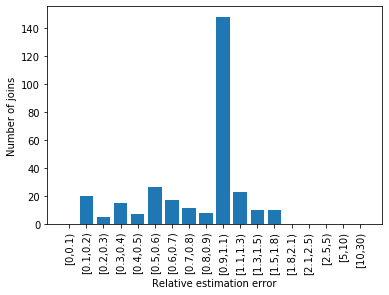

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

frequencies = get_query_frequencies()

all_factors = []
for _, row in results.iterrows():
    frequency = frequencies[row['QUERY_HASH1']]
    for _ in range(frequency):
        all_factors.append(row['RELATIVE_ERROR'])
#factors = results['RELATIVE_ERROR']

#factors = list(map(lambda x: x if x >= 0 else -1/x, factors))

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.8, 2.1, 2.5, 5, 10, 30]

values = histogram(all_factors, bins)
print(values)
thirty_percent_range = values[7] + values[8] + values[9] + values[10]
print(f"within 30%: {thirty_percent_range}/{sum(values)} ({100*thirty_percent_range/sum(values)}%)")
x = np.arange(len(values))
labels = list([f"[{low},{high})" for low, high in zip(bins, bins[1:])])

fig, ax = plt.subplots()

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Relative estimation error")
ax.set_ylabel("Number of joins")
ax.bar(x, values)
ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
#plt.title("Histogram of relative estimation errors")


extension = '' if SIDED else '_all'

plt.savefig(f'/home/aloeser/Downloads/MA-Figures/pngs/operatoreval/join_materialize_probe_shipdate{extension}.png', dpi=600, bbox_inches='tight')
plt.show()

In [36]:
percentile_bounds = [[1, 1.5], [1.5, 3], [3, 100]]
percentiles = []

for bound in percentile_bounds:
    mi = bound[0]
    ma = bound[1]
    high = results[results['RELATIVE_ERROR'] < ma]
    high = high[high['RELATIVE_ERROR'] >= mi]
    low = results[results['RELATIVE_ERROR'] <= 1/mi]
    low = low[low['RELATIVE_ERROR'] > 1/ma]    
    percentiles.append(len(low) + len(high))
    
np.array(percentiles) * 100 / len(results)
#33 44

array([64.66165414, 20.30075188, 15.03759398])

In [22]:
import sklearn.metrics

ESTIMATE_COLUMN = "RUNTIME_ESTIMATE"
MEASURED_COLUMN = "RUNTIME_CLUSTERED"

frequencies = get_query_frequencies()

estimates_ms = results.apply(lambda x: x[ESTIMATE_COLUMN] * frequencies[x['QUERY_HASH1']] / 1e6, axis=1)
measured_ms = results.apply(lambda x: x[MEASURED_COLUMN] * frequencies[x['QUERY_HASH1']] / 1e6, axis=1)


mse_nanoseconds = sklearn.metrics.mean_squared_error(measured_ms, estimates_ms)
#sum_relative_error = results[ESTIMATE_COLUMN].sum / results(MEASURED_COLUMN).sum()



def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

print(f"there are {len(results)} scans")
print(f"total estimate: {estimates_ms.sum()}")
print(f"total measured: {measured_ms.sum()}")
print(f"MSE: {mse_nanoseconds}")
print(f"SMAPE: {smape(measured_ms, estimates_ms)}")


there are 90 scans
total estimate: 8138.0127090000005
total measured: 4121.819638
MSE: 8359.430380234993
SMAPE: 74.85793508090416


In [38]:
def eval_scans(table_name):
    m = create_model(table_name, 2)

    m.estimate_total_runtime([CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
    #m.estimate_total_runtime(['l_shipdate', 'l_orderkey'], 'l_orderkey', [20, 50])
    assert len(m.scan_estimates[m.scan_estimates['RUNTIME_ESTIMATE'] < 0]) == 0, "not all runtimes computed"

    #CLUSTERED_STATISTICS_PATH = "~/Dokumente/repos/example_plugin/TPC-H__SF_10.000000__RUNS_10__TIME_500__ENCODING_DictionaryFSBA"
    CLUSTERED_STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/{CLUSTERING_COLUMN}-100"
    #CLUSTERED_STATISTICS_PATH = f"~/Dokumente/repos/example_plugin/stats/final/tpch/sf10_r10/l_shipdate-20_l_orderkey-50"
    #CLUSTERED_STATISTICS_PATH = f"/home/aloeser/Dokumente/repos/example_plugin/stats/final/tpcds/sf10-2d/04-ss_sold_time_sk-100_ss_ticket_number-1"
    
    path = f"{CLUSTERED_STATISTICS_PATH}/table_scans.csv"
    clustered_scans = pd.read_csv(path, sep='|')
    clustered_scans = clustered_scans[clustered_scans['TABLE_NAME'] == table_name]
    clustered_scans = clustered_scans.sort_values(['QUERY_HASH', 'DESCRIPTION'])
    
    print(f"there are {len(m.scan_estimates)} scan estimates")
    print(f"there are {len(clustered_scans)} clustered scans")
    
    m.scan_estimates.sort_values(['QUERY_HASH', 'DESCRIPTION'], inplace=True)
    result = pd.DataFrame()
    result['QUERY_HASH'] = np.array(clustered_scans['QUERY_HASH'])
    result['rti'] = np.array(m.scan_estimates['time_per_input_row'])
    result['COLUMN_NAME'] = np.array(clustered_scans['COLUMN_NAME'])
    result['DESCRIPTION1'] = np.array(m.scan_estimates['DESCRIPTION'])
    result['DESCRIPTION2'] = np.array(clustered_scans['DESCRIPTION'])
    result['QUERY_HASH1'] = np.array(m.scan_estimates['QUERY_HASH'])
    result['QUERY_HASH2'] = np.array(clustered_scans['QUERY_HASH'])
    result['RUNTIME_BASE'] = np.array(m.scan_estimates['RUNTIME_NS'])
    result['RUNTIME_ESTIMATE'] = np.array(m.scan_estimates.apply(lambda row: row['RUNTIME_ESTIMATE'] / m.query_frequency(row['QUERY_HASH']), axis=1), dtype=np.int64)
    result['RUNTIME_CLUSTERED'] = np.array(clustered_scans['RUNTIME_NS'])
    
    # make sure we match all operators
    matches = result.apply(lambda row: row['DESCRIPTION1'] == row['DESCRIPTION2'] and row['QUERY_HASH1'] == row['QUERY_HASH2'], axis=1)
    assert matches.all(), "not all rows match"
    
    result['TOTAL_ERROR'] = result['RUNTIME_CLUSTERED'] - result['RUNTIME_ESTIMATE']
    result['RELATIVE_ERROR'] = result['RUNTIME_CLUSTERED'] / result['RUNTIME_ESTIMATE']
    
    return result
    
CLUSTERING_COLUMN = "l_shipdate"
results = eval_scans("lineitem")
#results = results[CLUSTERING_COLUMN == results['COLUMN_NAME']]
#results = results["l_quantity" == results['COLUMN_NAME']]
#results = results[results['COLUMN_NAME'] == 'l_receiptdate']
#results = results[results['RELATIVE_ERROR'] != 1.0]
results[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'rti', 'TOTAL_ERROR', 'RELATIVE_ERROR']].sort_values(['RUNTIME_CLUSTERED'], ascending=False)
#results[['QUERY_HASH', 'RUNTIME_CLUSTERED']].sort_values(['RUNTIME_CLUSTERED'], ascending=False)
results.to_csv('detailed_estimates_shipdate_orderkey.csv')

there are 90 scan estimates
there are 90 clustered scans


[7, 13, 0, 19, 13, 12, 0, 1, 0, 13, 8, 1, 1, 0, 0, 0, 1, 1]
within 30%: 22/90 (24.444444444444443%)


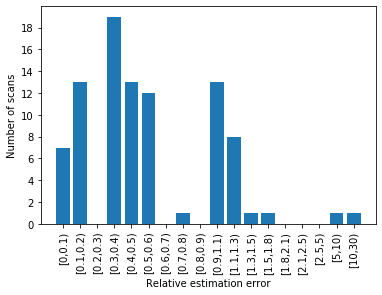

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

frequencies = get_query_frequencies()

all_factors = []
for _, row in results.iterrows():
    frequency = frequencies[row['QUERY_HASH1']]
    for _ in range(frequency):
        all_factors.append(row['RELATIVE_ERROR'])
#factors = results['RELATIVE_ERROR']

#factors = list(map(lambda x: x if x >= 0 else -1/x, factors))

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.3, 1.5, 1.8, 2.1, 2.5, 5, 10, 30]

values = histogram(all_factors, bins)
print(values)
thirty_percent_range = values[7] + values[8] + values[9] + values[10]
print(f"within 30%: {thirty_percent_range}/{sum(values)} ({100*thirty_percent_range/sum(values)}%)")

x = np.arange(len(values))
labels = list([f"[{low},{high})" for low, high in zip(bins, bins[1:])])

fig, ax = plt.subplots()

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Relative estimation error")
ax.set_ylabel("Number of scans")
ax.bar(x, values)
ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
#plt.title("Histogram of relative estimation errors")

#plt.savefig(f'/home/aloeser/Downloads/operatoreval/scan_partkey.pdf', bbox_inches='tight')
#plt.savefig(f'/home/aloeser/Downloads/MA-Figures/pngs/operatoreval/scan_shipdate.png', dpi=600, bbox_inches='tight')
plt.show()

In [40]:
percentile_bounds = [[1, 1.5], [1.5, 3], [3, 100]]
percentiles = []

for bound in percentile_bounds:
    mi = bound[0]
    ma = bound[1]
    high = results[results['RELATIVE_ERROR'] < ma]
    high = high[high['RELATIVE_ERROR'] >= mi]
    low = results[results['RELATIVE_ERROR'] <= 1/mi]
    low = low[low['RELATIVE_ERROR'] > 1/ma]    
    percentiles.append(len(low) + len(high))
    
np.array(percentiles) * 100 / len(results)

array([25.55555556, 50.        , 24.44444444])

In [16]:
assert_correct_statistics_loaded()

def extract_single_table(table_scans, table_name):
    return table_scans[table_scans['TABLE_NAME'] == table_name]

def default_benchmark_config():    
    if BENCHMARK == "TPCH":
        config = {
            'lineitem': [['l_shipdate', 2]],
            'orders': [['o_orderdate', 2]]
        }
    elif BENCHMARK == "TPCDS":
        config = dict()
    else:        
        raise Exception("unknown benchmark, please provide a default config")
    return config

def get_correlations():
    if BENCHMARK == "TPCH":
        correlations = {
            'lineitem': {
                'l_shipdate': ['l_receiptdate', 'l_commitdate'],
                'l_receiptdate': ['l_shipdate', 'l_commitdate'],
            }
        }
    elif BENCHMARK == "TPCDS":
        correlations = dict()
    else:
        raise Exception("unknown benchmark, please provide correlation information")
        
    return correlations


def format_table_clustering(clustering_config):
    # input format: List of [ [(column, split)+ ], sorting_column, runtime ]
    # output format: List of [ (column, split)+ ] - sorting column integrated if necessary
    
    assert len(clustering_config) == 3, "config should have exactly three entries: clustering columns, sort column, runtime"
    clustering_columns = clustering_config[0]
    assert len(clustering_columns) <= 3, "atm the model is at most 3-dimensional"
    #print(f"clustering columns are {clustering_columns}")
    last_clustering_column = clustering_columns[-1]
    last_clustering_column_name = last_clustering_column[0]
    #print(f"last column is {last_clustering_column_name}")
    sorting_column = clustering_config[1]
    #print(f"sort column is {sorting_column}")
    
    result = clustering_columns
    if last_clustering_column_name != sorting_column:
        result = clustering_columns + [(sorting_column, 1)]
        
    #print(f"in: {clustering_config}")
    #print(f"out: {result}")
    
    return result

def get_config_name(clustering_config):
    # Input: config-dict
    
    # List of lists. Each secondary list contains clustering information for a table
    table_configs = [clustering_config[table] for table in clustering_config]
    config_entries = [[f"{config_entry[0]}-{config_entry[1]}" for config_entry in config] for config in table_configs]
    table_entries = ["_".join(config) for config in config_entries]
    return "_".join(table_entries)


#model = create_model("lineitem", 2)
#model.table_scans['original_unprunable_part'] = np.array(model.table_scans['original_unprunable_part'], dtype=np.int32)
#model.table_scans[model.table_scans['COLUMN_NAME'] == 'o_comment']

Outdated code fragments (older model versions) are kept below.

In [ ]:
assert False, "This assertion failure only serves to stop execution here when clicking Cells->Run all. You can safely ignore it."